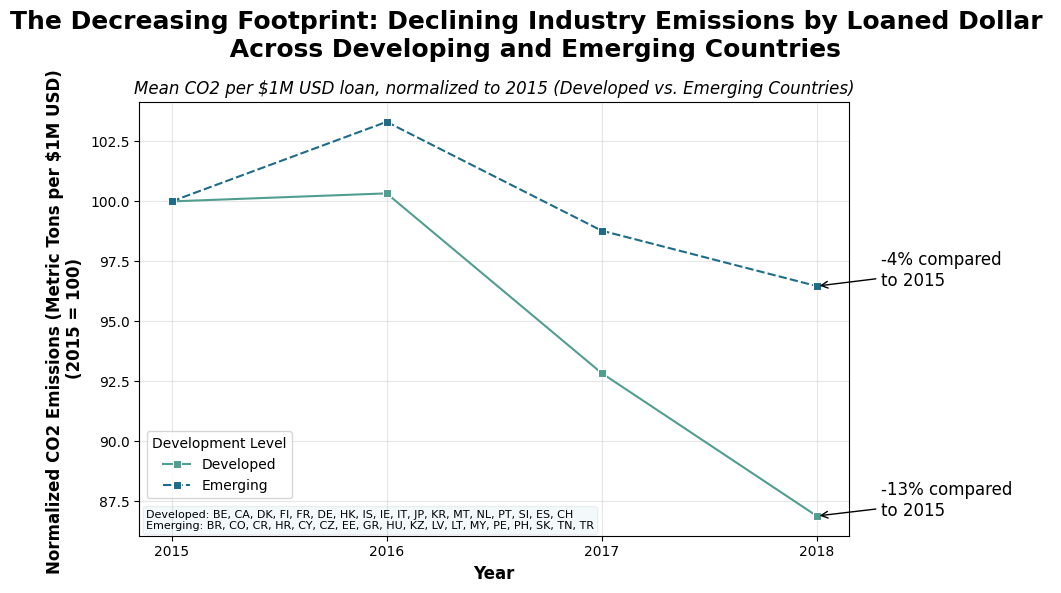

In [11]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


path = Path("./dataset/22_Carbon_Footprint_of_Bank_Loans.csv")
df = pd.read_csv(path)

# transform data to long format
df_long = df.copy().melt(
    id_vars=["Country", "ISO2", "ISO3", "Indicator", "Unit", "Source", "CTS Code", "CTS Name", "CTS Full Descriptor"],
    var_name="Year",
    value_name="Value"
)

df_long["Year"]=df_long["Year"].astype(int)
df_long=df_long.sort_values(["Country","Year"]).reset_index(drop=True)

df_pivot = df_long.pivot_table(
    index=["Country", "ISO2", "ISO3", "Year"],
    columns="CTS Code",
    values="Value"
).reset_index()

# Economic Development Groups
development_groups = {
    'Developed': ['BE', 'CA', 'DK', 'FI', 'FR', 'DE', 'HK', 'IS', 'IE',
                  'IT', 'JP', 'KR', 'MT', 'NL', 'PT', 'SI', 'ES', 'CH'],
    'Emerging': ['BR', 'CO', 'CR', 'HR', 'CY', 'CZ', 'EE', 'GR', 'HU',
                 'KZ', 'LV', 'LT', 'MY', 'PE', 'PH', 'SK', 'TN', 'TR'],
    #'Developing': ['BN', 'ID', 'BG']  # Note: Added BG to developing based on common classifications
}

def get_development(country_code):
    for dev_level, countries in development_groups.items():
        if country_code in countries:
            return dev_level
    return np.nan

# Filter for years after 2015
df_2015 = df_pivot[df_pivot['Year'] >= 2015].copy()
df_2015['development'] = df_2015['ISO2'].apply(get_development)

# Group by Development and Year
development_means = df_2015.groupby(['development', 'Year']).agg({
    'ECFLIN': 'mean',
    'ISO2': 'count'
}).rename(columns={'ISO2': 'ISO2'}).reset_index()

# figure 1

plt.figure(figsize=(10, 6))
sns.lineplot(data=development_means, x='Year', y='ECFLIN',
             hue='development', marker='s', style='development', palette="crest")
plt.suptitle("The Decreasing Footprint: Declining Industry Emissions by Loaned Dollar \n Across Developing and Emerging Countries", fontsize=18, fontweight="bold")
plt.title('Mean CO2 per $1M USD loan, normalized to 2015 (Developed vs. Emerging Countries)', fontsize=12, style='italic')
plt.xticks(range(2015,2019,1))
plt.ylabel('Normalized CO2 Emissions (Metric Tons per $1M USD) \n(2015 = 100)', fontsize=12,  fontweight="bold")
plt.xlabel("Year", fontsize=12, fontweight="bold")

## emerging annotations
emerging_annotation_loc =  (2018, development_means.query("Year == 2018 and development == 'Emerging'")['ECFLIN'].values[0])
emerging_ECLFIN_diff = 100 - emerging_annotation_loc[1] 
plt.annotate(
    f"-{emerging_ECLFIN_diff:.0f}% compared\nto 2015",
    xy=emerging_annotation_loc,
    xytext = (emerging_annotation_loc[0]+0.3, emerging_annotation_loc[1]),
    arrowprops=dict(arrowstyle="->"),
    fontsize=12
)

## emerging annotations
developed_annotation_loc =  (2018, development_means.query("Year == 2018 and development == 'Developed'")['ECFLIN'].values[0])
developed_ECLFIN_diff = 100 - developed_annotation_loc[1] 
plt.annotate(
    f"-{developed_ECLFIN_diff:.0f}% compared\nto 2015",
    xy=developed_annotation_loc,
    xytext = (developed_annotation_loc[0]+0.3, developed_annotation_loc[1]),
    arrowprops=dict(arrowstyle="->"),
    fontsize=12
)

## legend 
textstr = (
    "Developed: BE, CA, DK, FI, FR, DE, HK, IS, IE, IT, JP, KR, MT, NL, PT, SI, ES, CH\n"
    "Emerging: BR, CO, CR, HR, CY, CZ, EE, GR, HU, KZ, LV, LT, MY, PE, PH, SK, TN, TR"
)

plt.gca().text(0.01, 0.01, textstr, transform=plt.gca().transAxes,
               fontsize=8, va='bottom', ha='left',
               bbox=dict(boxstyle='round,pad=0.3', alpha=0.05))

plt.grid(True, alpha=0.3)
plt.legend(title='Development Level', bbox_to_anchor=(0.0005,0.07), loc='lower left')
plt.tight_layout()



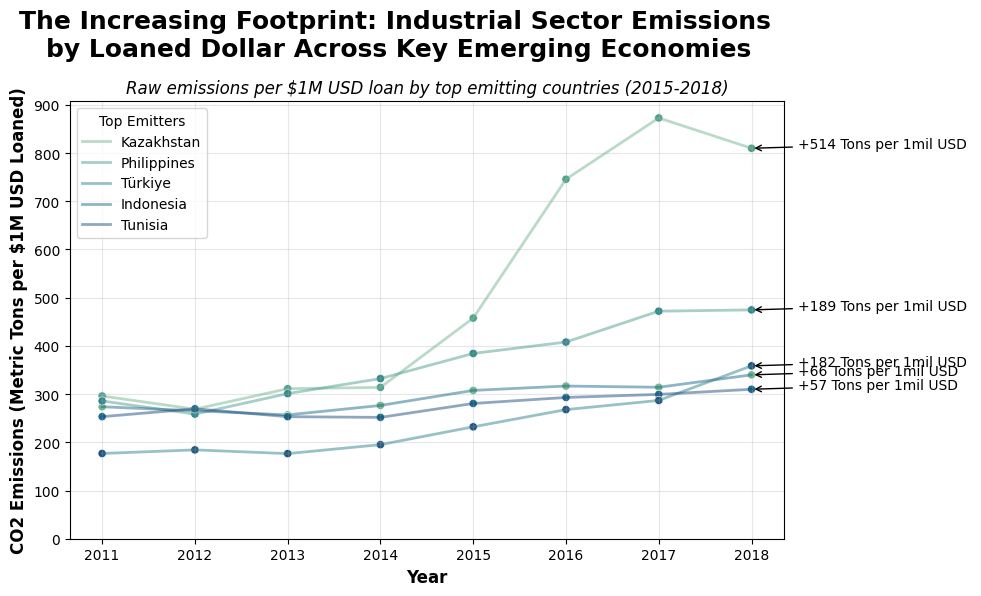

In [8]:
# figure 2

top_emitters = ["Kazakhstan, Rep. of", "Philippines", "Türkiye, Rep. of", "Indonesia","Tunisia"]

top_emitters_df = df_long[df_long['Country'].isin(top_emitters)]
top_emitters_df = top_emitters_df[top_emitters_df['Year']>=2011]
top_emitters_df =top_emitters_df[top_emitters_df['CTS Code']=='ECFLI']
top_emitters_df = top_emitters_df.sort_values(["Country", "Year"])

plt.figure(figsize=(8,6))
sns.lineplot(
    data=top_emitters_df,
    x="Year",
    y="Value",
    hue="Country",
    hue_order=top_emitters,
    alpha=0.5,
    linewidth=2,
    palette="crest"
)
sns.scatterplot(
    data=top_emitters_df,
    x="Year",
    y="Value",
    hue="Country",
    alpha=1,
    palette="crest",
    legend=False
)
plt.suptitle("The Increasing Footprint: Industrial Sector Emissions \nby Loaned Dollar Across Key Emerging Economies", fontsize=18, fontweight="bold")
plt.title("Raw emissions per $1M USD loan by top emitting countries (2015-2018)", fontsize=12, style="italic")
plt.tight_layout()
plt.xticks(range(2011,2019,1))
plt.ylim(0, None)
plt.yticks(range(0, 1000, 100))
plt.grid(True,alpha=0.3)
plt.ylabel("CO2 Emissions (Metric Tons per $1M USD Loaned)", fontsize=12, fontweight="bold")
plt.xlabel("Year", fontsize=12,fontweight="bold")

## Legend
new_labels=["Kazakhstan", "Philippines","Türkiye","Indonesia", "Tunisia" ]
ax=plt.gca()
rename_map = {top_emitters[i] : new_labels[i] for i in range(len(new_labels))}
handles, labels=ax.get_legend_handles_labels()
new_labels = [rename_map.get(lbl,lbl) for lbl in labels]
ax.legend(handles, new_labels, title="Top Emitters")


# annotations
per_country_difference = top_emitters_df.query('Year==2018').sort_values(by="Country")['Value'].reset_index()['Value'] - top_emitters_df.query('Year==2011').sort_values(by='Country')['Value'].reset_index()['Value']

diffs = { sorted(top_emitters)[i] : per_country_difference[i] for i in range(len(top_emitters))}

for country, diff in diffs.items(): 

    sub = top_emitters_df[(top_emitters_df["Country"] == country) &
                          (top_emitters_df["Year"] == 2018)] 
    
    x = sub["Year"].values[0]
    y = sub["Value"].values[0]

    
    text = f"+{diff:.0f} Tons per 1mil USD "
    ax.annotate(text,
            xy=(x, y),
            xytext=(x + 0.5, y ),
            fontsize=10,
            arrowprops=dict(arrowstyle="->"))
